In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import sys
import time
import numpy as np
import random
import matplotlib.pyplot as plt

from utils import *
log = logger(True) ; log("We're logging :)") #Log will print whatever it's given if this first arg is true

# Auto-reloading of modules in iPython
%load_ext autoreload
%autoreload 2

# CONSTS
SAVE_EVERY = 20
SEQ_SIZE = 25
RANDOM_SEED = 11
VALIDATION_SIZE = 0.15
LR = 1e-3
N_EPOCHS = 100
NUM_LAYERS, HIDDEN_SIZE = 1, 150
DROPOUT_P = 0
model_type = 'lstm'
use_cuda = torch.cuda.is_available() ; log("use_cuda is: %s" % use_cuda)
torch.manual_seed(RANDOM_SEED)
INPUT = 'data/music.txt'  # Music
RESUME = False
CHECKPOINT = 'ckpt_mdl_{}_ep_{}_hsize_{}_dout_{}'.format(model_type, N_EPOCHS, HIDDEN_SIZE, DROPOUT_P)

We're logging :)
use_cuda is: False


In [2]:
# READ IN DATA FILE
f = open(INPUT,"r")
data, buffer = [], ''
store = False
for line in f:
    if line == '<start>\n':
        buffer += line
    elif line == '<end>\n':
        buffer += line
        data += [buffer]
        buffer = ''
    else:
        buffer += line
f.close()

# We only want songs which are at least as big as our batch size +1
data = [ song for song in data if len(song) > SEQ_SIZE + 10 ]
log(data[0])
log('=====> Data loaded')

<start>
X:1
T: La Montfarine
Z:Transcrit et/ou corrig? par Michel BELLON - 2005-07-24
Z:Pour toute observation mailto:galouvielle@free.fr
M: 4/4
L: 1/8
Q:1/4=186
FGF B=AG G=AG F2F FGF {F}F2E EFE|
{E}E2D FGF B=AG G=AG {F}F2F FED C2G D2E|F3 {F}F/2 ED E3/2D/2|
EC FE E2 DC|DC C2 GD2E|F3F/2F/2 DE FD|EC B,C D2 B,G|
cB =A2 FG2E|F3F GF B=A|GG =AG F2 FF|GF F/2F3/2 EE FE|
E/2E3/2 DF GF B=A|GG =AG F/2F3/2 FF|ED C2 GD2E|F3F/2F/2 ED E3/2D/2|
EC FE E2 DC|DC C2 GD2E|F3F/2F/2 DE FD|EC B,C D2 B,G|
cB =A2 FF G=A|B3
G2_A G/2G3/2-|GF/2F/2 ED F2 EB,|CD EF GB AG|
A3A GA F2|F/2F/2F EF D3/2B,/2 B,B,|CD EF GA GF|G3B/2B/2 AB G2|
GG/2G/2 FG E2 EB/2B/2|AG BA GG AB|c3c/2c3/2d f2|ed eG c2 BB|
AB dc BG AD|E3F GF BA|GG AG F2 FF|GF F/2F3/2 EE FE|
E/2E3/2 DF GF BA|GG AG F/2F3/2 FF|ED C2 GD2E|F2- F/2
<end>

=====> Data loaded


In [3]:
char_idx = ''.join(set(list(open(INPUT,'r').read())))
char_list = list(char_idx)

# NOW SPLIT INTO TRAIN/VALIDATION SETS
num_train = len(data)
indices = list(range(num_train))
split_idx = int(np.floor(VALIDATION_SIZE * num_train))

# Shuffle data and split
np.random.seed(RANDOM_SEED)
np.random.shuffle(indices)
train_idxs, valid_idxs = indices[split_idx:], indices[:split_idx]

train_len, valid_len = len(train_idxs), len(valid_idxs)
log('Number of unique characters: %s' % len(char_idx))
log('Original data length: %s' % len(data))
log('Training data length: %s'% train_len)
log('Validation data length: %s' % valid_len)
assert(train_len + valid_len == len(data)), 'Train_len + valid_len should == len(data)'

Number of unique characters: 93
Original data length: 1120
Training data length: 952
Validation data length: 168


In [4]:
# Some utils
def tic(): return time.time()

def toc(tic, msg=None):
    s = time.time() - tic
    m = int(s / 60)
    if msg:
        return '{}m {}s {}'.format(m, int(s - (m * 60)), msg)
    return '{}m {}s'.format(m, int(s - (m * 60)))

# Gives us a random slice of size SEQ_SIZE + 1 so we can get a train/target.
def rand_slice(data, slice_len=SEQ_SIZE):
    d_len = len(data)
    s_idx = random.randint(0, d_len - slice_len)
    e_idx = s_idx + slice_len + 1
    return data[s_idx:e_idx]

test_slice = rand_slice(data[0])
log(test_slice)

def seq_to_tensor(seq):
    '''
    create tensor from char seq
    '''
    out = torch.zeros(len(seq)).long()
    for i, c in enumerate(seq):
        out[i] = char_idx.index(c)
    return out

t = seq_to_tensor(test_slice)
log('T is a: ', type(t), ' of size ', len(t))

def train_slice(data, slice_len=50):
    '''
    creates a random training set
    '''
    slice_i = rand_slice(data, slice_len=slice_len)
    seq = seq_to_tensor(slice_i[:-1])
    target = seq_to_tensor(slice_i[1:])
    return Variable(seq), Variable(target)

def train_batch(data, b_size=100, slice_len=50):
    batch_seq = torch.zeros(b_size, slice_len).long()
    batch_target = torch.zeros(b_size, slice_len).long()
    for idx in range(b_size):
        seq, target = train_slice(data, slice_len=slice_len)
        batch_seq[idx] = seq.data
        batch_target[idx] = target.data
    return Variable(batch_seq), Variable(batch_target)

# Given a song, return a sequence/target as a variable
def song_to_seq_target(song):
    a_slice = rand_slice(song)
    seq = seq_to_tensor(a_slice[:-1])
    target = seq_to_tensor(a_slice[1:])
    assert(len(seq) == len(target)), 'SEQ AND TARGET MISMATCH'
    return Variable(seq), Variable(target)

s, t = song_to_seq_target(data[0])
log(s.size())
assert(t.data[0] == s.data[1])

F/2F3/2 EE FE|
E/2E3/2 DF 
T is a:  <class 'torch.LongTensor'>  of size  26
torch.Size([25])


In [5]:
class MusicRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model='gru', num_layers=1):
        super(MusicRNN, self).__init__()
        self.model = model
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        self.embeddings = nn.Embedding(input_size, hidden_size)
        if self.model == 'lstm':
            self.rnn = nn.LSTM(hidden_size, hidden_size, num_layers)
        elif self.model == 'gru':
            self.rnn = nn.GRU(hidden_size, hidden_size, num_layers)
        else:
            raise NotImplementedError
        self.out = nn.Linear(self.hidden_size, self.output_size)
        self.drop = nn.Dropout(p=DROPOUT_P)
        
    def init_hidden(self):
        if self.model == 'lstm':
            self.hidden = (Variable(torch.zeros(self.num_layers, 1, self.hidden_size)),
                           Variable(torch.zeros(self.num_layers, 1, self.hidden_size)))
        elif self.model == 'gru':
            self.hidden = Variable(torch.zeros(self.num_layers, 1, self.hidden_size))
        
    def forward(self, seq):
        embeds = self.embeddings(seq.view(1, -1))
        rnn_out, self.hidden = self.rnn(embeds.view(1,1,-1), self.hidden)
        rnn_out = self.drop(rnn_out)
        output = self.out(rnn_out.view(1,-1))
        return output

In [6]:
def some_pass(seq, target, fit=True):
    model.init_hidden() # Zero out the hidden layer
    model.zero_grad()   # Zero out the gradient
    some_loss = 0
    
    for i, c in enumerate(seq):
        output = model(c)
        some_loss += loss_function(output, target[i])
        
    if fit:
        some_loss.backward()
        optimizer.step()
    
    return some_loss.data[0] / len(seq)

In [7]:
# Model
if RESUME:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    
    checkpoint = torch.load('./checkpoint/' + CHECKPOINT + '.tEP_NUM_SVAED')
    model = checkpoint['model']
    loss = checkpoint['loss']
    v_loss = checkpoint['v_loss']
    losses = checkpoint['losses']
    v_losses = checkpoint['v_losses']
    start_epoch = checkpoint['epoch']
    
else:
    print('==> Building model..')
    in_size, out_size = len(char_idx), len(char_idx)
    model = MusicRNN(in_size, HIDDEN_SIZE, out_size, model_type, NUM_LAYERS)
    loss, v_loss = 0, 0
    losses, v_losses = [], []
    start_epoch = 0

if use_cuda:
    net.cuda()
    net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_function = nn.CrossEntropyLoss()

==> Building model..


In [8]:
# Train
time_since = tic()
for epoch in range(start_epoch, N_EPOCHS):
    # Training
    for i, song_idx in enumerate(train_idxs):
        this_loss = some_pass(*song_to_seq_target(data[song_idx]))
        loss += this_loss
        
        msg = '\rTraining Epoch: {}, {:.2f}% iter: {} Time: {} Loss: {:.4}'.format(
             epoch, (i+1)/len(train_idxs)*100, i, toc(time_since), this_loss)
        sys.stdout.write(msg)
        sys.stdout.flush()
    print()
    losses.append(loss / len(train_idxs))
        
    # Validation
    for i, song_idx in enumerate(valid_idxs):
        this_loss = some_pass(*song_to_seq_target(data[song_idx]), fit=False)
        v_loss += this_loss
        
        msg = '\rValidation Epoch: {}, {:.2f}% iter: {} Time: {} Loss: {:.4}'.format(
             epoch, (i+1)/len(valid_idxs)*100, i, toc(time_since), this_loss)
        sys.stdout.write(msg)
        sys.stdout.flush()
    print()
    v_losses.append(v_loss / len(valid_idxs))
    
    # Save checkpoint.
    if epoch % SAVE_EVERY == 0 and start_epoch != epoch or epoch == N_EPOCHS - 1:
        print('=======>Saving..')
        state = {
            'model': model.module if use_cuda else model,
            'loss': losses[-1],
            'v_loss': v_losses[-1],
            'losses': losses,
            'v_losses': v_losses,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
#         torch.save(state, './checkpoint/ckpt.t%s' % epoch)
        torch.save(state, './checkpoint/' + CHECKPOINT + '.t%s' % epoch)
    
    # Reset loss
    loss, v_loss = 0, 0

Training Epoch: 0, 100.00% iter: 951 Time: 0m 38s Loss: 1.74
Validation Epoch: 0, 100.00% iter: 167 Time: 0m 41s Loss: 2.123
Training Epoch: 1, 100.00% iter: 951 Time: 1m 12s Loss: 1.631
Validation Epoch: 1, 100.00% iter: 167 Time: 1m 14s Loss: 1.964
Training Epoch: 2, 100.00% iter: 951 Time: 1m 45s Loss: 1.474
Validation Epoch: 2, 100.00% iter: 167 Time: 1m 48s Loss: 3.655
Training Epoch: 3, 100.00% iter: 951 Time: 2m 20s Loss: 1.896
Validation Epoch: 3, 100.00% iter: 167 Time: 2m 23s Loss: 2.179
Training Epoch: 4, 100.00% iter: 951 Time: 2m 55s Loss: 1.211
Validation Epoch: 4, 100.00% iter: 167 Time: 2m 58s Loss: 1.915
Training Epoch: 5, 100.00% iter: 951 Time: 3m 29s Loss: 1.284
Validation Epoch: 5, 100.00% iter: 167 Time: 3m 32s Loss: 2.636
Training Epoch: 6, 100.00% iter: 951 Time: 4m 3s Loss: 1.4964
Validation Epoch: 6, 100.00% iter: 167 Time: 4m 6s Loss: 2.432
Training Epoch: 7, 100.00% iter: 951 Time: 4m 40s Loss: 1.528
Validation Epoch: 7, 100.00% iter: 167 Time: 4m 43s Loss: 

/Users/vchiley/anaconda3/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type MusicRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Training Epoch: 21, 100.00% iter: 951 Time: 12m 46s Loss: 1.414
Validation Epoch: 21, 100.00% iter: 167 Time: 12m 49s Loss: 1.554
Training Epoch: 22, 100.00% iter: 951 Time: 13m 25s Loss: 1.172
Validation Epoch: 22, 100.00% iter: 167 Time: 13m 28s Loss: 2.383
Training Epoch: 23, 100.00% iter: 951 Time: 13m 58s Loss: 1.349
Validation Epoch: 23, 100.00% iter: 167 Time: 14m 1s Loss: 2.421
Training Epoch: 24, 100.00% iter: 951 Time: 14m 31s Loss: 1.448
Validation Epoch: 24, 100.00% iter: 167 Time: 14m 33s Loss: 2.171
Training Epoch: 25, 100.00% iter: 951 Time: 15m 6s Loss: 1.4469
Validation Epoch: 25, 100.00% iter: 167 Time: 15m 9s Loss: 2.543
Training Epoch: 26, 100.00% iter: 951 Time: 15m 37s Loss: 1.329
Validation Epoch: 26, 100.00% iter: 167 Time: 15m 40s Loss: 2.192
Training Epoch: 27, 100.00% iter: 951 Time: 16m 8s Loss: 1.3869
Validation Epoch: 27, 100.00% iter: 167 Time: 16m 11s Loss: 2.824
Training Epoch: 28, 100.00% iter: 951 Time: 16m 38s Loss: 1.073
Validation Epoch: 28, 100.00

Validation Epoch: 83, 100.00% iter: 167 Time: 47m 4s Loss: 1.934
Training Epoch: 84, 100.00% iter: 951 Time: 47m 34s Loss: 1.271
Validation Epoch: 84, 100.00% iter: 167 Time: 47m 37s Loss: 0.3267
Training Epoch: 85, 100.00% iter: 951 Time: 48m 9s Loss: 1.3473
Validation Epoch: 85, 100.00% iter: 167 Time: 48m 11s Loss: 1.204
Training Epoch: 86, 100.00% iter: 951 Time: 48m 39s Loss: 1.2319
Validation Epoch: 86, 100.00% iter: 167 Time: 48m 43s Loss: 1.374
Training Epoch: 87, 100.00% iter: 951 Time: 49m 16s Loss: 1.1373
Validation Epoch: 87, 100.00% iter: 167 Time: 49m 18s Loss: 2.917
Training Epoch: 88, 100.00% iter: 951 Time: 49m 47s Loss: 1.298
Validation Epoch: 88, 100.00% iter: 167 Time: 49m 51s Loss: 2.016
Training Epoch: 89, 100.00% iter: 951 Time: 50m 24s Loss: 1.6678
Validation Epoch: 89, 100.00% iter: 167 Time: 50m 27s Loss: 1.823
Training Epoch: 90, 100.00% iter: 951 Time: 51m 0s Loss: 1.14837
Validation Epoch: 90, 100.00% iter: 167 Time: 51m 3s Loss: 1.574
Training Epoch: 91, 1

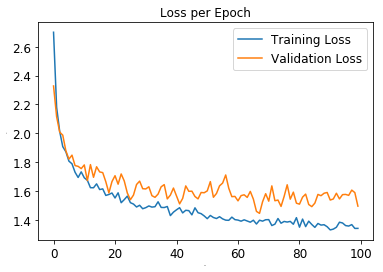

In [9]:
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=0)      # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=12)   # fontsize of the figure title
plt.plot(losses, label='Training Loss')
plt.plot(v_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.show()

In [10]:
def write_song(prime_str='<start>', max_len=1000, temp=0.8):
    model.init_hidden()
    
    # "build up" hidden state using the beginging of a song '<start>'
    creation = '<start>'
    prime = Variable(seq_to_tensor(creation))
    for i in range(len(prime)-1):
        _ = model(prime[i])

    # Generate rest of sequence
    for j in range(max_len):
        out = model(Variable(seq_to_tensor(creation[-1]))).data.view(-1)
        
        out = np.array(np.exp(out/temp))
        dist = out / np.sum(out)

        # Add predicted character to string and use as next input        
        creation += char_idx[np.random.choice(len(dist), p=dist)]
        if creation[-5:] == '<end>':
            break

    return creation

In [11]:
log(write_song(max_len=1000, temp=0.8))

<start>
X:92
T:Frankie Gavourite
T:Over
D:Derrik Gaolan Johnnor Stratterle
C:Claude Grinaire Ginas (1924)
M:C|
L:1/4
K:G
GA G/A/B/c/ | d/c/d/c/ dB c2 | B2z2 | d/2c/2F/2 EF | GG/A/ Bc | d4 ||
K:G
DGGB d2BG|GBAG EGDE| D2 (3GFE D2:|
|:dg|(3efg fg|a2ba gfge|defa gfge|dB (3ABd|gecA cAFA|
fedB c2dc|~B3G FGAF|GEDE ~G3A|B2G2 GFGA|BGBd BG~G2|BAGF GED2:|2 BEFA BGcG|EGDE G2AB|
ABde f2 (3dcd|ecAG FDD2|
~a3a gaec|dA (3Bcd A2GA|BA~G2 ABcA|~G3FE D2FG|AGFD DEFG|AFDE FE~E2|EDEF G2AB|
G2GA Bcdf|~g3a bg~g2|dg~g2 edBG|AFDF GBdB|ADFE D2:|
|:eB~B2 BAGF|ABAF D2FG|Addf (3gab aged|cded ^cAFD|EGAB cAGE|
FGAB AGFG|Ad~d2 cAFA|dcBA BAFA|~B3d c2BA|G2Bd edBG|ABde fdeA|fB~B2 AGFG|AcBA GFGA|B2G2 B2GB|AFAd dcAF|
G2AB cdBd|fddc BG~G2|ABAG ADFA|~G3F G2FD|EGFG AFD2|~D3A ABcA|FA~F2 DF~G2|FAde f2dB|ABAG E2dA|GDGB GBdB|1 GBAG AGFG:|2 g2ag (3fga gdfg|abag edcB|ABcA GECE||
|:deff e2ce|defg faed|cAGF EG~G2|EDFA AGGE|D2DE D2Bd|[1 BAGF G2AG|F2AA ABde|fd~d2 edcA|(3BAG FA d2|
dBAG FGAB|c2cB cAcB|ADFA ~B3A|GEFD D2ED|
EG~E2 B2BA|GGGF

In [12]:
# Heatmap generation
# Needed to make this 100x100 in order to be able to print it out as a nice lookin grid...
heatmap = np.zeros((100,100))
for neuron_idx in range(len(char_idx)-1):
    for j, char in enumerate(char_idx):
        #model.init_hidden()
        out = model(Variable(seq_to_tensor(char))).data.view(-1)[neuron_idx]
        heatmap[neuron_idx,j] = out

In [13]:
# Adapted from https://stackoverflow.com/questions/25071968/heatmap-with-text-in-each-cell-with-matplotlibs-pyplot
plt.rc('font', size=100)          # controls default text sizes
plt.rc('axes', titlesize=100)     # fontsize of the axes title
plt.rc('axes', labelsize=0)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=100)    # fontsize of the tick labels
plt.rc('ytick', labelsize=100)    # fontsize of the tick labels
plt.rc('legend', fontsize=100)    # legend fontsize
plt.rc('figure', titlesize=100)  # fontsize of the figure title

title = "Heatmap For Music RNN"
xlabel= "Character"
ylabel="Neuron ID"
data =  np.reshape(heatmap[0,:], (10,-1))
plt.figure(figsize=np.shape(heatmap))
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
c = plt.pcolor(data, edgecolors='k', linewidths=4, cmap='RdBu_r', vmin=-1.0, vmax=1.0)

def show_values(pc, fmt="%.2f", **kw):
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        idx = int(x-.5) + 10*int(y-.5)
        if idx < len(char_idx):
            ax.text(x, y, repr(char_list[idx])[1:-1], fontsize=180, ha="center", va="center", color=color, **kw)

show_values(c)
plt.colorbar(c)

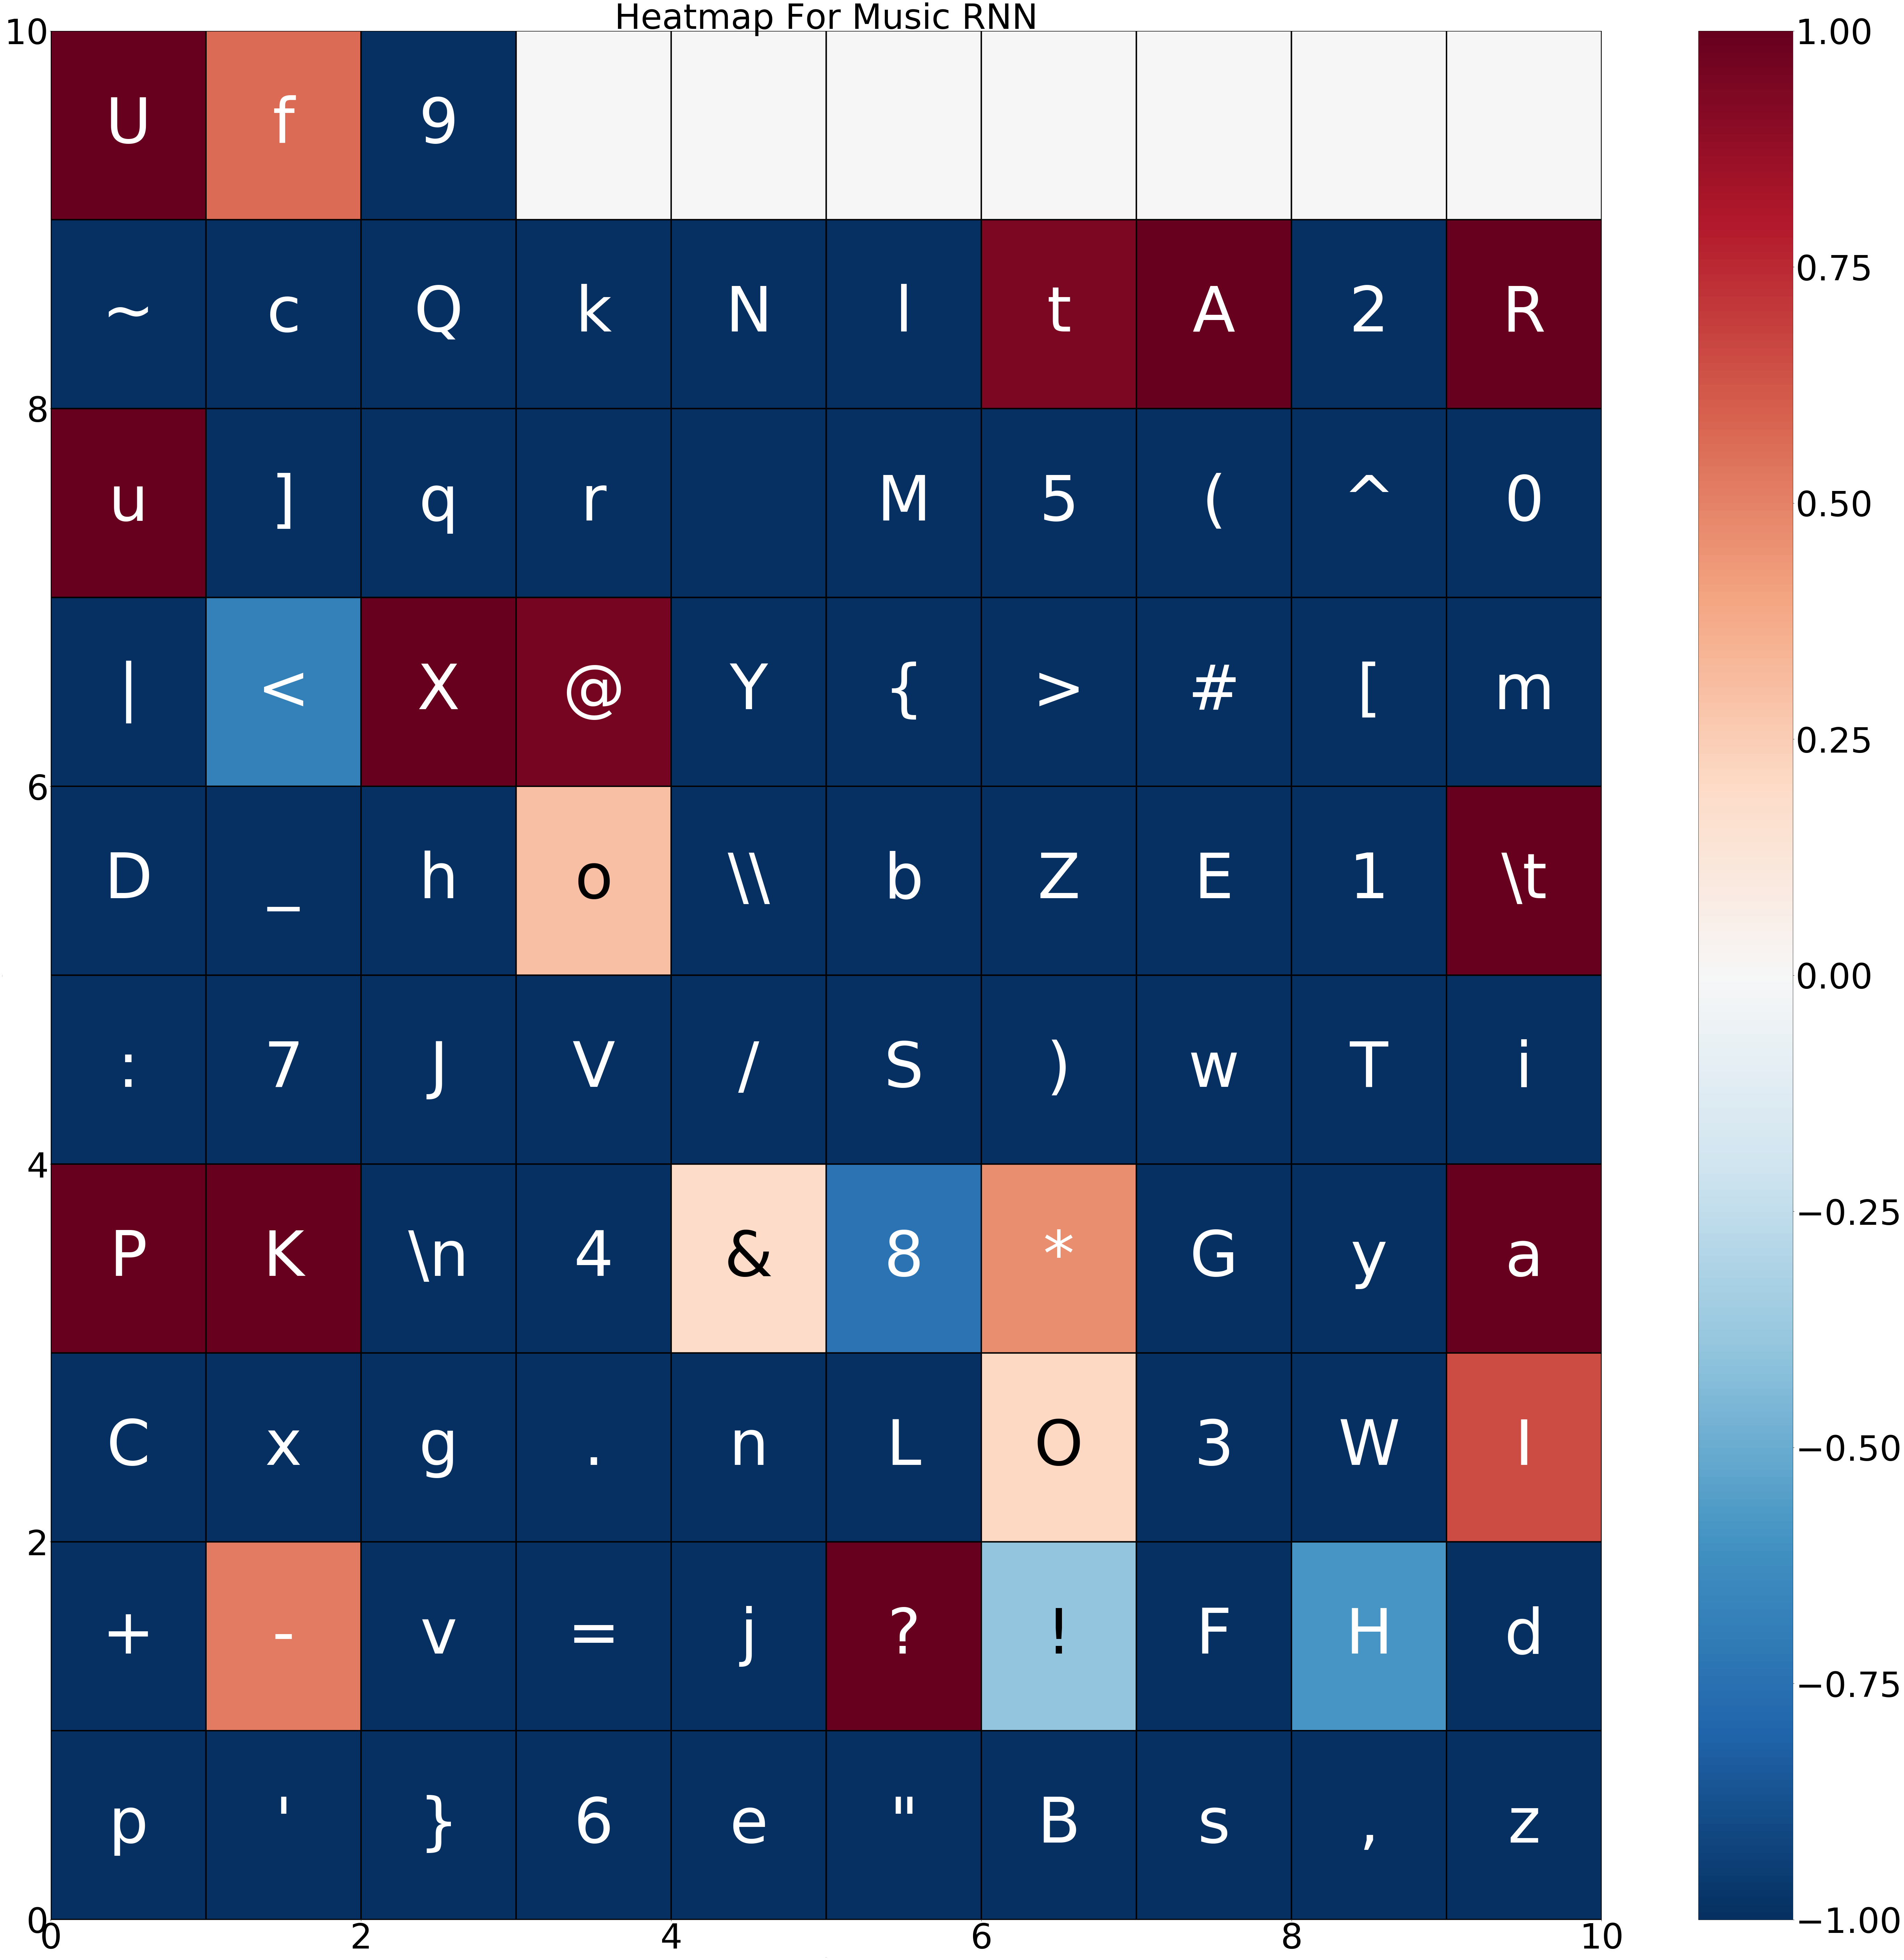

In [14]:
plt.show()

In [15]:
CHECKPOINT

'ckpt_mdl_lstm_ep_100_hsize_150_dout_0'